In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display,clear_output
%matplotlib inline

## Среда(Роборука)

Роборука имеет 2 шарнира, положение которых задано углами s[0] и s[1]. Скорость изменения углов задана s[2] и s[3], где s - вектор состояния.

Контроллер u[0] и u[1] линейно воздействует на скорость.

В начале эпизода положение серого манипулятора выбирается случайно

Задача заключается в том, чтобы синий(управляемый) и серый(случайный) манипуляторы находились в одном положении

Необходимо реализовать управление методом LQR


In [5]:
F = np.concatenate([np.eye(4),np.zeros([4,2])],axis=1) + \
            np.concatenate([np.zeros([4,2]),np.eye(4)],axis=1)
F

array([[1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.]])

In [4]:
class RoboHand():
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    GAMMA = 0.0 # velocity penalty 
    DELTA = 0.0 # acceleration penaly
    REWARD_THRESHOLD = 1e-3
        
    def reset(self,init_state = None):
        
        if init_state: self.state = init_state
        else: self.state = np.random.rand(4)*np.array([2*np.pi,2*np.pi,0,0])
        self.done = False        
        self.goal = np.random.rand(2)*np.pi # angle coordinates of goal position
        self.show = False
        return self.state
    
    def move_goal(self):
        # TODO implement moving goal
        return self.goal
    
    def get_env_dynamic(self):
        F = np.concatenate([np.eye(4),np.zeros([4,2])],axis=1) + \
            np.concatenate([np.zeros([4,2]),np.eye(4)],axis=1)
        f = np.zeros(4)
        
        C = -np.array(
            [[0.5,0,0,0,0,0],
             [0,0.5,0,0,0,0],
             [0,0,self.GAMMA,0,0,0],
             [0,0,0,self.GAMMA,0,0],
             [0,0,0,0,self.DELTA,0],
             [0,0,0,0,0,self.DELTA]])
        c = -np.array([-self.goal[0],-self.goal[1],0,0,0,0])
        
        return F,f,C,c
    
    def step(self,a):
        if not self.done:
            self.goal = self.move_goal() 
            F,f,C,c = self.get_env_dynamic()
            xu  = np.concatenate([self.state,a])
            self.state, reward = F.dot(xu) + f, xu.T.dot(C).dot(xu) + c.dot(xu)
            self.done = reward > self.REWARD_THRESHOLD
        else: reward = 0
        if self.show: self.render;
        return self.state, reward, self.done, ''
    
    def render(self):
        plt.clf();
        fig, ax = plt.subplots();
        
        ax.plot([0,np.sin(self.goal[0]),np.sin(self.goal[0])+np.sin(self.goal[:2].sum())],
                 [0,np.cos(self.goal[0]),np.cos(self.goal[0])+np.cos(self.goal[:2].sum())],
                'o-', color='999999', linewidth=7,markersize=12)
        
        ax.plot([0,np.sin(self.state[0]),np.sin(self.state[0])+np.sin(self.state[:2].sum())],
                 [0,np.cos(self.state[0]),np.cos(self.state[0])+np.cos(self.state[:2].sum())],
                 'bo-', linewidth=5,markersize=10)
        
        
        ax.set_xlim([-2.2,2.2]);
        ax.set_ylim([-2.2,2.2]);
        ax.axis('off');        
        return fig
    
    def sample_action(self):
        return np.random.randn(2)*0.05

/home/kposminin/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


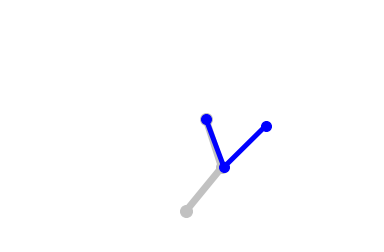

'Reward -2.0912235917216506'

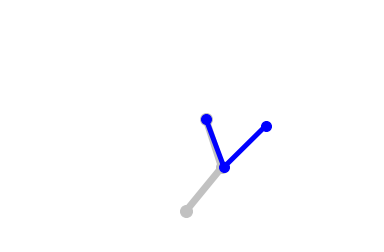

In [6]:
import time
env = RoboHand()
s = env.reset()

for _ in range(20):
    a = env.sample_action()
    s,r,d,_ = env.step(a)
    clear_output(wait=True)
    display(env.render())
    display(f'Reward {r}')
    time.sleep(0.15)

## LQR

#### Алгоритм

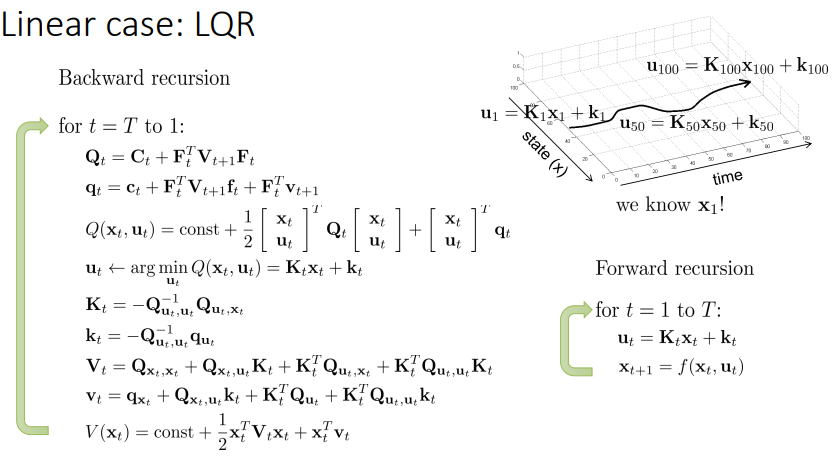